<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Hp_optimization_without_stratified_K_Fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install -U keras-tuner

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [55]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [74]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [76]:
train_data_stand_pca.shape

(131, 9)

#Building Network

In [0]:
from tensorflow import keras

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [0]:
from tensorflow.keras import layers

In [0]:
from tensorflow.keras import regularizers

In [0]:
from tensorflow.keras.optimizers import SGD

In [0]:
from kerastuner.tuners import RandomSearch

In [0]:
def build_model(hp):
  model = keras.models.Sequential()

#  model.add(layers.Dense(units=(hp.Int('units', min_value=3, max_value=8, step=1)), 
#                         activation='relu', input_shape=(9,)))

  model.add(layers.Dense(4, activation='relu', input_shape=(9,)))
  model.add(layers.Dense(3, activation='softmax'))
#  sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
#  decay = hp.Choice('decay', [1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
  momentum = hp.Choice('momentum', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
  model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum, decay=1e-6, nesterov=True), 
                loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##Prova Train Test Split

In [0]:
from sklearn.model_selection import train_test_split


In [0]:
X_train, X_val, y_train, y_val = train_test_split(train_data_stand_pca, train_labels_dec,
                                                    stratify=train_labels_dec,
                                                    test_size=0.20,
                                                    random_state=30)


In [86]:
y_train.count(2)

43

#Keras tuner RandomSearch

In [87]:
num_epochs = 20
  
one_hot_partial_train_targets = to_categorical(y_train)
one_hot_val_targets = to_categorical(y_val)

tuner = RandomSearch(build_model, objective='val_acc', max_trials=40, 
                       executions_per_trial=5, directory='/content/my_dir', project_name='RandomSearch')
  
tuner.search_space_summary()

tuner.search(X_train, one_hot_partial_train_targets, validation_data=(X_val, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  


INFO:tensorflow:Reloading Oracle from existing project /content/my_dir/RandomSearch/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/RandomSearch/tuner0.json


INFO:tensorflow:Oracle triggered exit


In [88]:
tuner.search_space_summary()


In [89]:
tuner.results_summary()

In [0]:
random_params=tuner.get_best_hyperparameters()[0]

In [0]:
random_model = tuner.hypermodel.build(random_params)

In [92]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'learning_rate': 0.01, 'momentum': 0.4}

In [0]:
best_model = tuner.get_best_models()[0]

##Train the best model RandomSearch

Per la valutazione del modello ottimizzato sul validation set uso la Stratified K-Fold

In [0]:
from sklearn.model_selection import StratifiedKFold

In [95]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

5

In [96]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  1   2   4   5   6   8  10  11  12  13  14  15  16  17  20  21  22  23
  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  46  47  48  49  50  52  55  58  59  60  61  62  63  64  65  67  68
  69  70  71  73  74  75  76  77  78  79  81  82  83  84  85  86  87  88
  89  91  92  93  94  96  97  98  99 100 101 102 103 104 106 107 108 110
 113 115 116 117 118 119 121 122 123 124 126 127 129 130] TEST: [  0   3   7   9  18  19  28  44  45  51  53  54  56  57  66  72  80  90
  95 105 109 111 112 114 120 125 128]
TRAIN: [  0   1   2   3   5   7   8   9  10  11  12  13  14  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  33  34  37  38  39  40  41  42
  44  45  46  47  48  49  51  53  54  55  56  57  58  61  62  63  64  66
  67  69  70  71  72  73  75  77  79  80  81  82  83  84  85  87  88  89
  90  92  94  95  96  97  98  99 100 101 103 105 106 107 109 110 111 112
 114 115 116 117 118 119 120 121 122 124 125 126 127 128 129] TEST: [  4   6  15 

In [97]:
#num_epochs = 50
all_acc_histories_RS = []
all_loss_histories_RS = []
all_val_acc_histories_RS = []
all_val_loss_histories_RS = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  history_RS = best_model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history_RS = history_RS.history['acc']
  all_acc_histories_RS.append(acc_history_RS)

  loss_history_RS = history_RS.history['loss']
  all_loss_histories_RS.append(loss_history_RS)

  acc_val_history_RS = history_RS.history['val_acc']
  all_val_acc_histories_RS.append(acc_val_history_RS)

  loss_val_history_RS = history_RS.history['val_loss']
  all_val_loss_histories_RS.append(loss_val_history_RS)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 104 samples, validate on 27 samples
Epoch 1/20
104/104 [==============================] - 0s 857us/sample - loss: 0.9580 - acc: 0.5385 - val_loss: 1.2543 - val_acc: 0.5556
Epoch 2/20
104/104 [==============================] - 0s 257us/sample - loss: 0.9319 - acc: 0.5865 - val_loss: 1.2717 - val_acc: 0.5185
Epoch 3/20
104/104 [==============================] - 0s 252us/sample - loss: 0.9182 - acc: 0.6058 - val_loss: 1.2793 - val_acc: 0.5185
Epoch 4/20
104/104 [==============================] - 0s 259us/sample - loss: 0.9124 - acc: 0.6250 - val_loss: 1.2941 - val_acc: 0.5556
Epoch 5/20
104/104 [==============================] - 0s 302us/sample - loss: 0.8937 - acc: 0.6154 - val_loss: 1.3110 - val_acc: 0.5556
Epoch 6/20
104/104 [==============================] - 0s 290us/sample - loss: 0.8979 - acc: 0.6154 - val_loss: 1.3059 - val_acc: 0.5556
Epoch 7/20
104/104 [==============================] - 0s 407us/sample - loss: 0.8891 - acc: 0.6154 - val_loss: 1.2847 - val_acc: 0.5556
Epo

In [0]:
history_dict = history_RS.history

In [99]:
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

##Plotting training and validation loss RandomSearch


In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

In [0]:
average_acc_history_RS = [np.mean([x[i] for x in all_acc_histories_RS]) for i in range(num_epochs)]
average_loss_history_RS = [np.mean([x[i] for x in all_loss_histories_RS]) for i in range(num_epochs)]
average_val_acc_history_RS = [np.mean([x[i] for x in all_val_acc_histories_RS]) for i in range(num_epochs)]
average_val_loss_history_RS = [np.mean([x[i] for x in all_val_loss_histories_RS]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche

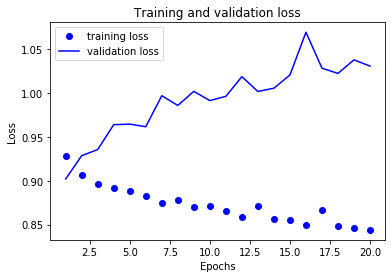

In [103]:
plt.plot(epochs, average_loss_history_RS, 'bo', label='training loss')
plt.plot(epochs, average_val_loss_history_RS, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy RandomSearch

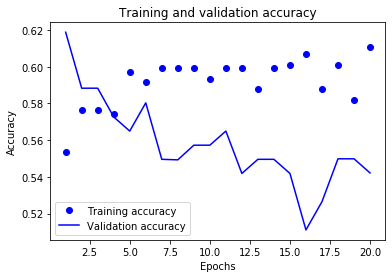

In [104]:
plt.plot(epochs, average_acc_history_RS, 'bo', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_RS, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 